# Lesson 9: More Decisions

## Intro to Quantified Cognition

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/master/notebooks/09_More_Decisions.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- More discussion of RunDEMC
- More discussion of PDA
- Extensions to LBA model
- Model comparisons


## Example: Speed--Accuracy trade-off

- Sometimes we have to make fast decisions
- Other times we just need to be as accurate as possible.

## *ONLY* if on Google Colab

In [ ]:
# to install RunDEMC
!pip install git+https://github.com/compmem/RunDEMC.git


In [ ]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/master/notebooks/decision_data.csv

## Load and process the data

In [ ]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

from RunDEMC.density import kdensity
from RunDEMC import Model, Param, dists, calc_bpic

In [ ]:
# load in the data
dat = pd.read_csv('decision_data.csv', index_col=0)
dat = dat[dat.cond != 'Neutral']
dat['rt_acc'] = dat['rt']
dat.loc[dat.correct==0,'rt_acc'] = -dat['rt']
dat.head()

## Linear Ballistic Accumlator (LBA)

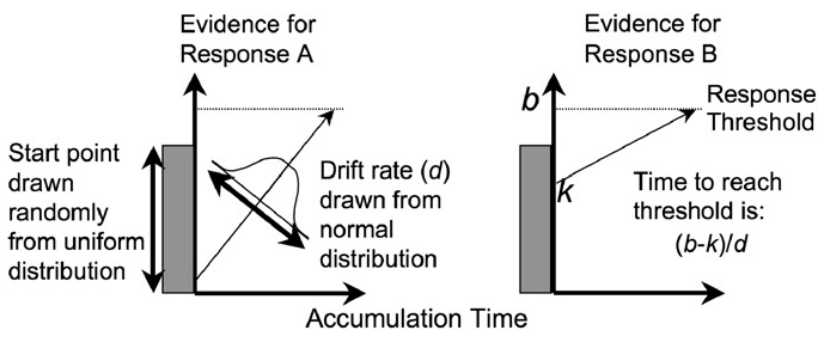

In [ ]:
def lba_sim(I=(1.0,1.5), A=.1, S=1.0, b=1.0, t0=0.0, 
            num_sims=1000, max_time=2., I_scales_S=False, **kwargs):
    # set drift rate from inputs
    dr = np.float64(I)
    
    # set the number of choices
    nc = len(dr)
    
    # pick starting points
    k = np.random.uniform(0., A, (num_sims, nc))
    
    # pick drifts
    if I_scales_S:
        # calc S from drift rates
        S = np.sqrt((dr**2).sum())*S
        
    # must make sure at least one d is greater than zero for each sim
    d = np.random.normal(dr, S, (num_sims, nc))
    
    # see where there are none above zero
    #ind = np.all(d<=0.0,axis=1)
    #while np.any(ind):
    #    d[ind,:] = np.random.normal(dr,S,(ind.sum(),nc))
    #    ind = np.all(d<=0.0,axis=1)

    # clip it to avoid divide by zeros
    d[d<=0.0] = np.finfo(dr.dtype).eps

    # calc the times for each
    t = (b-k)/d

    # see the earliest for each resp
    inds = t.argmin(1)
    times = t.take(inds+np.arange(t.shape[0])*t.shape[1])

    # process into choices
    times += t0
    
    # get valid responses
    resp_ind = times < (max_time)
    resp = inds+1
    resp[~resp_ind] = 0
    
    # return as data frame
    return pd.DataFrame.from_dict({'response':resp, 'rt':times})
    


In [ ]:
x = lba_sim()
x.head()

In [ ]:
# set up the sim
nsims = 5000
cond='Accuracy'
ndat = (dat['cond']==cond).sum()

# normed histogram
def dhist(dat, nsims, alpha=.3, color='b'):
    p,b = np.histogram(dat,bins='auto',density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nsims
    return plt.bar(b[1:]-w,p,width=w,alpha=.3,color=color)

# normed pdf
xvals = np.linspace(0.1,2.0,100)
def dplot(dat, nsims, color='b', lw=2.):
    p,xx = kdensity(dat, extrema=(xvals.min(),xvals.max()), xx=xvals)
    p *= float(len(dat))/nsims
    plt.plot(xx, p, color=color, lw=2.)

# put it all together
def run_lba(d1=1.0, d2=2.0, A=.1, b=1.0, t0=0.0, S=1.0, I_scales_S=False):
    # run the LBA model
    res = lba_sim(I=(d1, d2), A=A, S=S, b=b, num_sims=nsims, max_time=2.0, t0=t0, 
                  I_scales_S=I_scales_S)

    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    dplot(res.loc[res['response'] == 2, 'rt'], nsims, color='b')
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    dplot(res.loc[res['response'] == 1, 'rt'], nsims, color='r')
    #ylim(0,5.0)
    plt.xlim(0,2.0)

In [ ]:
# set up new figure
plt.figure(figsize=(10,6))

# try different params!
d1 = 1.4   # drift for incorrect between 0 and 5
d2 = 2.8   # drift for correct between 0 and 5
A = 0.3    # starting point range between 0 and 1
b = 1.8    # thresh between 0 and 5
t0 = 0.265   # non-decision time between 0 and 1
S = 1.5    

# call the function
run_lba(d1=d1, d2=d2, A=A, b=b, t0=t0, S=S, I_scales_S=True)

## Using computers to test hypotheses

In [ ]:
from RunDEMC import Model, Param, dists

In [ ]:
# grab the beh data of interest
dat_A_1 = np.array(dat[(dat['cond']=='Accuracy')&(dat['correct']==0)]['rt'])
dat_A_2 = np.array(dat[(dat['cond']=='Accuracy')&(dat['correct']==1)]['rt'])
num_A = float((dat['cond']=='Accuracy').sum())
prop_A_1 = len(dat_A_1)/num_A
prop_A_2 = len(dat_A_2)/num_A
dat_S_1 = np.array(dat[(dat['cond']=='Speed')&(dat['correct']==0)]['rt'])
dat_S_2 = np.array(dat[(dat['cond']=='Speed')&(dat['correct']==1)]['rt'])
num_S = float((dat['cond']=='Speed').sum())
prop_S_1 = len(dat_S_1)/num_S
prop_S_2 = len(dat_S_2)/num_S


In [ ]:
# Test change in threshold

# set up the params
params = [Param(name='d1', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='b_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.trunc_normal(.2, 1.0, 0., 1.0))]
param_names = [p.name for p in params]

# define the likelihood function
nsims = 10000
max_time = 2.0
extrema = (0, max_time)
S = 1.0
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,params in enumerate(pop):
        # get the params into a nice dict
        p = {param_names[j]: params[j] for j in range(len(params))}
    
        # first check for simple issues
        if (p['A'] > p['b_A']) or (p['A'] > p['b_S']) or np.any(params<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        res = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=S, b=p['b_A'], 
                      num_sims=nsims, max_time=max_time, t0=p['t0'])
        
        # process first response
        rts = res.loc[res['response'] == 1, 'rt']
        if len(rts)>2:
            pp,xx = kdensity(rts, extrema=extrema, xx=dat_A_1)
            pp *= float(len(rts))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # process second response
        rts = res.loc[res['response'] == 2, 'rt']
        if len(rts)>2:
            pp,xx = kdensity(rts, extrema=extrema, xx=dat_A_2)
            pp *= float(len(rts))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # then Speed
        res = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=S, b=p['b_S'], 
                      num_sims=nsims, max_time=max_time, t0=p['t0'])
        
        # process first response
        rts = res.loc[res['response'] == 1, 'rt']
        if len(rts)>2:
            pp,xx = kdensity(rts, extrema=extrema, xx=dat_S_1)
            pp *= float(len(rts))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # process second response
        rts = res.loc[res['response'] == 2, 'rt']
        if len(rts)>2:
            pp,xx = kdensity(rts, extrema=extrema, xx=dat_S_2)
            pp *= float(len(rts))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue

    return likes
        
# make the model
m_t = Model('thresh', params=params,
            like_fun=like_fun,
            like_args=(dat,),
            purify_every=5,
            verbose=True)


In [ ]:
# do some burnin
times = m_t.sample(25, burnin=True)

In [ ]:
plt.plot(m_t.weights[25:]);

In [ ]:
print("Best fitting params:")
burnin=5
m = m_t
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

In [ ]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(res.loc[res['response'] == 2, 'rt'], nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(res.loc[res['response'] == 1, 'rt'], nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(res.loc[res['response'] == 2, 'rt'], nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(res.loc[res['response'] == 1, 'rt'], nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);

In [ ]:
# Test change in drift rate

# set up the params
params = [Param(name='d1_A', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2_A', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d1_S', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2_S', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.trunc_normal(.2, 1.0, 0., 1.0))]
param_names = [p.name for p in params]

# define the likelihood function
nsims = 10000
max_time = 2.0
extrema = (0, max_time)
S = 1.0
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,params in enumerate(pop):
        # get the params into a nice dict
        p = {param_names[j]: params[j] for j in range(len(params))}
    
        # first check for simple issues
        if (p['A'] > p['b']) or np.any(params<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        res = lba_sim(I=(p['d1_A'], p['d2_A']), A=p['A'], S=S, b=p['b'], 
                      num_sims=nsims, max_time=max_time, t0=p['t0'])
        
        # process first response
        rts = res.loc[res['response'] == 1, 'rt']
        if len(rts)>2:
            pp,xx = kdensity(rts, extrema=extrema, xx=dat_A_1)
            pp *= float(len(rts))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # process second response
        rts = res.loc[res['response'] == 2, 'rt']
        if len(rts)>2:
            pp,xx = kdensity(rts, extrema=extrema, xx=dat_A_2)
            pp *= float(len(rts))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # then Speed
        res = lba_sim(I=(p['d1_S'], p['d2_S']), A=p['A'], S=S, b=p['b'], 
                      num_sims=nsims, max_time=max_time, t0=p['t0'])
        
        # process first response
        rts = res.loc[res['response'] == 1, 'rt']
        if len(rts)>2:
            pp,xx = kdensity(rts, extrema=extrema, xx=dat_S_1)
            pp *= float(len(rts))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # process second response
        rts = res.loc[res['response'] == 2, 'rt']
        if len(rts)>2:
            pp,xx = kdensity(rts, extrema=extrema, xx=dat_S_2)
            pp *= float(len(rts))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue

    return likes
        
# make the model
m_d = Model('drift', params=params,
            like_fun=like_fun,
            like_args=(dat,),
            purify_every=5,
            verbose=True)


In [ ]:
# do some burnin
times = m_d.sample(25, burnin=True)

In [ ]:
plt.plot(m_d.weights[25:]);

In [ ]:
print("Best fitting params:")
burnin=5
m = m_d
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

In [ ]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1_'+cond[0]], pp['d2_'+cond[0]]), A=pp['A'], S=1.0, b=pp['b'], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(res.loc[res['response'] == 2, 'rt'], nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(res.loc[res['response'] == 1, 'rt'], nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1_'+cond[0]], pp['d2_'+cond[0]]), A=pp['A'], S=1.0, b=pp['b'], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(res.loc[res['response'] == 2, 'rt'], nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(res.loc[res['response'] == 1, 'rt'], nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);